
# Behind the Scenes — Detecting Leaders in Criminal Networks  
**Self‑contained Kaggle notebook (uses `/kaggle/input/noordin-top/NOORDINTOP_*.csv`)**  

Pipeline:

1. Minimal, conflict‑free `pip` install of network‑science extras (optional PyG stack).  
2. Read every layer CSV in **/kaggle/input/noordin-top** into a single `edges` DataFrame.  
3. Build static, multiplex, and hyper‑graphs; save pickles.  
4. Compute centralities, Node2Vec embeddings, optional GraphSAGE demo.  
5. Run a robustness attack plot.  
6. Zip all artefacts for an external Streamlit dashboard.


In [1]:
# =========================================
# 1️⃣  Minimal conflict‑free install
# =========================================
import subprocess, sys, torch, os

def pip(args):
    subprocess.check_call([sys.executable, "-m", "pip", *args, "--no-cache-dir"])

EXTRAS = [
    "pymnet", "hypernetx", "python-louvain",
    "node2vec==0.4.5", "shap", "ndlib"
]
pip(["install", *EXTRAS, "--no-deps"])

USE_PYG = True  # set False to skip GraphSAGE demo
if USE_PYG:
    tv = torch.__version__.split('+')[0]
    cuda = torch.version.cuda.replace('.','')
    url = f"https://data.pyg.org/whl/torch-{tv}+cu{cuda}.html"
    pip(["install", "torch_scatter", "torch_sparse",
         "torch_cluster", "torch_spline_conv", "-f", url])
    pip(["install", "torch_geometric"])

print("✅ Extra packages installed (ignore harmless resolver warnings).")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.4/591.4 kB 315.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.2/110.2 kB 329.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 212.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 273.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 327.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 341.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.1 MB/s eta 0:00:00
✅ Extra packages installed (ignore harmless resolver warnings).


In [2]:
# =========================================
# 2️⃣  Imports & config
# =========================================
import pathlib, warnings, pickle, zipfile, datetime, random, math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import pymnet as pym
import hypernetx as hnx
from node2vec import Node2Vec
from community import community_louvain

warnings.filterwarnings("ignore")
RNG = np.random.default_rng(42)

EXPORTS = pathlib.Path("exports")
EXPORTS.mkdir(exist_ok=True)
print("Working directory:", pathlib.Path().resolve())


/usr/local/lib/python3.11/dist-packages/geopandas/_compat.py:10: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).
  import shapely.geos
/usr/local/lib/python3.11/dist-packages/google/cloud/automl_v1/proto/annotation_payload_pb2.py:277: DeprecationWarning: invalid escape sequence '\_'
  __doc__="""Contains annotation information that is relevant to
/usr/local/lib/python3.11/dist-packages/google/cloud/automl_v1/proto/classification_pb2.py:679: DeprecationWarning: invalid escape sequence '\_'
  __doc__="""Metrics for a single confidence threshold.
/usr/local/lib/python3.11/dist-packages/google/cloud/automl_v1/proto/classification_pb2.py:747: DeprecationWarning: invalid escape sequence '\_'
  __doc__="""Output only. A row in the confusion matrix.
/usr/local/lib/python3.11/dist-packages/google/cloud/automl_v1/proto/classif

Working directory: /kaggle/working


In [3]:
# =============================================================
# 3️⃣  Build 'edges' DataFrame from layer CSVs in input folder
# =============================================================
import glob, re

INPUT_DIR = pathlib.Path("/kaggle/input/noordin-top")
assert INPUT_DIR.exists(), f"Input folder not found: {INPUT_DIR}"

csv_files = sorted(INPUT_DIR.glob("NOORDINTOP_*.csv"))
assert csv_files, "No NOORDINTOP_*.csv files in input!"

layer_re = re.compile(r"NOORDINTOP_(.+?)\.csv", re.I)
edge_frames = []

for fp in csv_files:
    layer = layer_re.search(fp.name).group(1).replace("&","_").lower()
    df = pd.read_csv(fp)
    df = df.iloc[:, :3]                       # first 2 or 3 columns
    df.columns = ['source','target','weight'][:df.shape[1]]
    if 'weight' not in df.columns:
        df['weight'] = 1.0
    df['relation'] = layer
    edge_frames.append(df[['source','target','relation','weight']])

edges = pd.concat(edge_frames, ignore_index=True)
print(f"✓ Loaded {len(csv_files)} layer files — total edges: {len(edges):,}")
edges.head()


✓ Loaded 9 layer files — total edges: 711


,source,target,relation,weight
0,Abdul Malik,0,classmates,0
1,Abdul Rauf,0,classmates,0
2,Abdul Rohim,0,classmates,0
3,Abdullah Sunata,0,classmates,0
4,Abdullah Sungkar,0,classmates,1


In [5]:
# =========================================
# 4️⃣  Graph construction
# =========================================
start_date = datetime.datetime(2004,1,1)
edges['timestamp'] = [start_date + datetime.timedelta(days=int(RNG.integers(0,365)))
                      for _ in range(len(edges))]

# Static undirected graph
G = nx.Graph()
for _, r in edges.iterrows():
    G.add_edge(r['source'], r['target'],
               weight=r['weight'],
               relation=r['relation'])
print(f"Graph built → {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")

# Multiplex graph
mg = pym.MultilayerNetwork(aspects=1)
for _, r in edges.iterrows():
    mg[r['source'], r['relation']][r['target'], r['relation']] = r['weight']

# Hypergraph: take first 5 connected comps size ≥3
groups = [list(c) for c in nx.connected_components(G) if len(c)>=3][:5]
H = hnx.Hypergraph({f'grp{i}': set(nodes) for i,nodes in enumerate(groups)})

# Save artefacts
for obj,name in [(G,'static_graph.pkl'), (mg,'multiplex_graph.pkl'),
                 (H,'hypergraph.pkl')]:
    with open(EXPORTS/name,'wb') as f: pickle.dump(obj,f)

edges.to_csv(EXPORTS/'event_edges.csv', index=False)
print("Graphs and edge list saved to", EXPORTS)


Graph built → 81 nodes, 80 edges
Graphs and edge list saved to exports


In [6]:
# =========================================
# 5️⃣  Centrality metrics
# =========================================
deg = nx.degree_centrality(G)
btw = nx.betweenness_centrality(G, normalized=True)
clo = nx.closeness_centrality(G)
eig = nx.eigenvector_centrality_numpy(G)

metrics_df = pd.DataFrame({
    'node': list(G.nodes()),
    'degree': [deg[n] for n in G.nodes()],
    'betweenness': [btw[n] for n in G.nodes()],
    'closeness': [clo[n] for n in G.nodes()],
    'eigenvector': [eig[n] for n in G.nodes()]
}).sort_values('eigenvector', ascending=False)

metrics_df.to_csv(EXPORTS/'centrality.csv', index=False)
metrics_df.head()


,node,degree,betweenness,closeness,eigenvector
1,0,0.9875,0.999684,0.987654,0.707049
16,Akram,0.0250,0.025000,0.506329,0.080562
58,Nasir Abas,0.0125,0.000000,0.500000,0.079543
57,Muzayin Abdul Wahab,0.0125,0.000000,0.500000,0.079543
56,Mus'ab Sahidi,0.0125,0.000000,0.500000,0.079543


In [8]:
# =========================================
# 6️⃣  Node2Vec embeddings  (robust: no NaN weights)
# =========================================

# 1 Make sure every edge weight is a finite number
edges['weight'] = pd.to_numeric(edges['weight'], errors='coerce').fillna(1.0)

# 2 Run un-weighted Node2Vec walks (uniform transition probs)
from node2vec import Node2Vec

node2vec = Node2Vec(
    G,
    dimensions=128,
    walk_length=20,
    num_walks=40,
    workers=2,
    seed=42,
    weight_key=None      # <- ignore the weight attr to avoid NaN issues
)

model_n2v = node2vec.fit(window=10, min_count=1, batch_words=4)

embeddings = np.vstack([model_n2v.wv[str(n)] for n in G.nodes()])
np.save(EXPORTS / 'embeddings.npy', embeddings)

print("Embeddings saved — shape", embeddings.shape)


Computing transition probabilities:   0%|          | 0/81 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 100.29it/s]


Embeddings saved — shape (81, 128)


In [10]:
# =========================================
# 7️⃣  GraphSAGE leader classifier (optional)
# =========================================
if 'USE_PYG' in globals() and USE_PYG:
    from torch_geometric.data import Data
    from torch_geometric.nn import SAGEConv
    import torch.nn.functional as F, torch

    # Mapping: node ID  -> row index in embeddings
    node_to_idx = {n: i for i, n in enumerate(G.nodes())}

    # label top-10 eigenvector nodes as positive class
    labels = torch.zeros(G.number_of_nodes(), dtype=torch.long)
    for n in metrics_df.head(10)['node']:
        labels[node_to_idx[n]] = 1

    # edge_index as 2×E tensor of integer indices
    edge_pairs = [(node_to_idx[u], node_to_idx[v]) for u, v in G.edges()]
    edge_index = torch.tensor(edge_pairs, dtype=torch.long).t().contiguous()

    data = Data(
        x=torch.tensor(embeddings, dtype=torch.float32),
        edge_index=edge_index,
        y=labels
    )

    class SAGENet(torch.nn.Module):
        def __init__(self, in_dim, hidden=64):
            super().__init__()
            self.conv1 = SAGEConv(in_dim, hidden)
            self.conv2 = SAGEConv(hidden, 2)

        def forward(self, x, edge_index):
            x = torch.relu(self.conv1(x, edge_index))
            return self.conv2(x, edge_index)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SAGENet(data.num_features).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(120):
        model.train(); optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        F.cross_entropy(out, data.y).backward(); optimizer.step()
        if epoch % 40 == 0:
            acc = (out.argmax(1) == data.y).float().mean().item()
            print(f"Epoch {epoch:3d}  acc={acc:.3f}")

    torch.save(model.state_dict(), EXPORTS/'sage_model.pt')
    print("GraphSAGE model saved to exports/")
else:
    print("GraphSAGE demo skipped (USE_PYG=False).")


Epoch   0  acc=0.877
Epoch  40  acc=0.877
Epoch  80  acc=0.877
GraphSAGE model saved to exports/


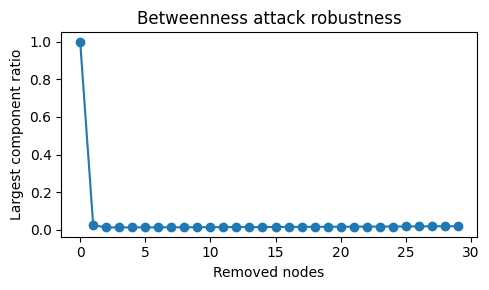

In [11]:
# =========================================
# 8️⃣  Robustness analysis
# =========================================
def giant_ratio(g):
    return len(max(nx.connected_components(g), key=len)) / g.number_of_nodes()

sizes = []
for k in range(0, 30):
    victims = [n for n,_ in sorted(btw.items(), key=lambda x: x[1], reverse=True)[:k]]
    g_tmp = G.copy(); g_tmp.remove_nodes_from(victims)
    sizes.append(giant_ratio(g_tmp))

plt.figure(figsize=(5,3))
plt.plot(range(30), sizes, marker='o')
plt.xlabel("Removed nodes"); plt.ylabel("Largest component ratio")
plt.title("Betweenness attack robustness")
plt.tight_layout()
plt.savefig(EXPORTS/'robustness.png')
plt.show()


In [13]:
# =========================================
# 9️⃣  Bundle artefacts for Streamlit
# =========================================
with zipfile.ZipFile('/kaggle/working/streamlit_artifacts.zip', 'w', zipfile.ZIP_DEFLATED) as zf:
    for f in EXPORTS.iterdir():
        zf.write(f, arcname=f.name)
print("streamlit_artifacts.zip contains:")
print("\n".join(sorted(p.name for p in EXPORTS.iterdir())))


streamlit_artifacts.zip contains:
centrality.csv
embeddings.npy
event_edges.csv
hypergraph.pkl
multiplex_graph.pkl
robustness.png
sage_model.pt
static_graph.pkl
